# Lab 4: Submitting Code on Supercomputer in R

### Objective:
Learn how to run R in parallel on a Supercomputer. Note: The data used in this lab is provided as part of a restricted access data agreement and cannot be used under any circumstances outside this lab. If you are interested in further analysis with this dataset outside of this exercise, you MUST obtain the explicit consent of Professor Christensen.

### Successful outcome:
Not only be able to write a parallel R script in foreach, but also be able to write PBS and Bash scripts to submit jobs through the terminal.

Remember to shut down your server when you are done by clicking Control Panel -> Shut Down Server

## Step 1: Preliminaries:

This is a very important first step, many people who did not finish this step may mess up multiple scripts and dependencies. This may cause other people to be unable to re-produce the outputs of this lab.

In [1]:
## clean the workspace's current variables
rm(list=ls())

## This function will check if a package is installed, and if not, install it
pkgTest <- function(x) {
  if (!require(x, character.only = TRUE))
  {
    install.packages(x, dep = TRUE)
    if(!require(x, character.only = TRUE)) stop("Package not found")
  }
}

## These lines load the required packages using 'pkgTest' function
packages <- c("readxl", "data.table", "ggmap", "ggplot2")
lapply(packages, pkgTest)
    
## the output should be multiple "NULL"s

Loading required package: readxl
Loading required package: data.table
Loading required package: ggmap
Loading required package: ggplot2


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

In [2]:
## find the current working directory
getwd()

[1] "/home/ubuntu/labs/Lab_4_Multi-Core_Processing_in_R"

## Step 2: Preprocessing

#### Main Goal: 
1. Read in datasets and the required files
2. Create new variables for modeling

The data that will be used in this lab come from daily listings in Airbnb.  There are two files -- one file contains property characteristics and the other contains daily bookings information.  In the pre-processing stage, you may need to remove NAs, change the data from "character" to "factor" or otherwise. Sometimes, you may need to create a new field for modeling. For example, you may need to change dates from daily into a quarterly aggregate.  In this case, we will generate a number of fields that will be used to construct a measure of aggregate daily revenue and potential revenue for each market (City) in the United States. 

In [3]:
## Read the input files under the current working directory
US_P <- readRDS("United_States_Property.rds")
US_D <- readRDS("United_States_Daily.rds")
print(nrow(US_D))

[1] 100000000


In [4]:
## Now we can examine the US Properties Dataset by printing the first 5 elements.
head(US_P)

Property.ID,Host.ID,Listing.Title,Property.Type,Listing.Type,Created.Date,Last.Scraped.Date,Country,State,City,⋯,Count.Reservation.Days.LTM,Count.Available.Days.LTM,Count.Blocked.Days.LTM,Number.of.Photos,Business.Ready,Instantbook.Enabled,Listing.URL,Listing.Main.Image.URL,Latitude,Longitude
87601,68654,Eugene Get-Away (Sun Room),House,Private room,2017-03-16,2017-05-31,United States,Oregon,Eugene,⋯,17,0,13,13,False,No,https://www.airbnb.com/rooms/87601,https://a0.muscache.com/im/pictures/1868780/1bdccf9f_original.jpg?aki_policy=x_large,44.00863,-123.19604
26012,109589,Sunny 2-story townhouse w garden,House,Entire home/apt,2010-04-15,2017-06-02,United States,New York,New York,⋯,100,5,260,31,True,No,https://www.airbnb.com/rooms/26012,https://a0.muscache.com/im/pictures/68664532/f74dd09e_original.jpg?aki_policy=x_large,40.68157,-73.98989
82963,451748,Palm Desert Oasis,House,Entire home/apt,2011-03-18,2017-06-01,United States,California,Palm Desert,⋯,3,27,0,36,False,No,https://www.airbnb.com/rooms/82963,https://a0.muscache.com/im/pictures/70531770/3eb2f137_original.jpg?aki_policy=x_large,33.71463,-116.37367
23472,91808,Cozy Cottage,Cabin,Entire home/apt,2010-03-12,2017-05-30,United States,Wisconsin,Verona,⋯,47,286,1,10,False,No,https://www.airbnb.com/rooms/23472,https://a0.muscache.com/im/pictures/123650/2df7b8c1_original.jpg?aki_policy=x_large,43.03177,-89.62797
44020,101521,2 Bedroom 1 Block to Fullerton L,Apartment,Entire home/apt,2010-08-07,2017-06-01,United States,Illinois,Chicago,⋯,65,128,17,18,False,No,https://www.airbnb.com/rooms/44020,https://a0.muscache.com/im/pictures/730606/d0ff831f_original.jpg?aki_policy=x_large,41.92673,-87.65731
94059,486032,"""Psycho""- Sigmund Freud Suite",Bed & Breakfast,Entire home/apt,2011-04-11,2017-06-01,United States,Massachusetts,Southbridge,⋯,34,172,8,35,False,No,https://www.airbnb.com/rooms/94059,https://a0.muscache.com/im/pictures/6978898/adb70aab_original.jpg?aki_policy=x_large,42.07687,-72.03798


In [5]:
## We can examine the US Bookings Dataset by printing the first 5 elements.
head(US_D)

,Property.ID,Date,Status,Price,Booked.Date,Reservation.ID
14375954,430340,2015-09-15,A,150,,NA
332654104,10596885,2016-09-29,B,90,,NA
400641975,13315681,2016-11-22,A,50,,NA
396729720,13183917,2016-09-25,A,180,,NA
348787386,11240038,2016-12-20,A,120,,NA
301907403,9394013,2015-11-08,A,100,,NA


In [6]:
## Creating the city & state field
US_P$City_State <- paste(US_P$City,"_", US_P$State, sep="")

In [7]:
## Select all unique markets using unique City X State pairs
Markets  <- unique(US_P$City_State, incomparables=FALSE)

## For this excercise we will only use the first 10 markets
Markets1 <- Markets[c(1,3,4,5,6)]
print(Markets1)

[1] "Eugene_Oregon"             "Palm Desert_California"   
[3] "Verona_Wisconsin"          "Chicago_Illinois"         
[5] "Southbridge_Massachusetts"


## Step 3: Modeling & Plotting

This step is used when the parallelization and modification could happen for a data analytic application. In our case, we will need to go through all of the cities in the market and plot them out in terms of "Revenue" and "Potential Revenue". 

In [8]:
## We can demonstrate the serial process by selecting one specific city
y <- Markets[1]
y

[1] "Eugene_Oregon"

In [9]:
## Choose market
TH_P <- subset(US_P, City_State==y)
head(TH_P)

,Property.ID,Host.ID,Listing.Title,Property.Type,Listing.Type,Created.Date,Last.Scraped.Date,Country,State,City,⋯,Count.Available.Days.LTM,Count.Blocked.Days.LTM,Number.of.Photos,Business.Ready,Instantbook.Enabled,Listing.URL,Listing.Main.Image.URL,Latitude,Longitude,City_State
1,87601,68654,Eugene Get-Away (Sun Room),House,Private room,2017-03-16,2017-05-31,United States,Oregon,Eugene,⋯,0,13,13,False,No,https://www.airbnb.com/rooms/87601,https://a0.muscache.com/im/pictures/1868780/1bdccf9f_original.jpg?aki_policy=x_large,44.00863,-123.1960,Eugene_Oregon
563,37609,161959,Feels like a forest cabin!,Bungalow,Entire home/apt,2010-07-06,2017-03-25,United States,Oregon,Eugene,⋯,45,13,6,False,No,https://www.airbnb.com/rooms/37609,https://a0.muscache.com/im/pictures/67162e4f-98cc-4087-9d1a-d03f421512e1.jpg,44.07781,-123.0899,Eugene_Oregon
1086,87035,105888,Quiet Suite in South Eugene Home,Guest suite,Private room,2011-04-01,2017-05-31,United States,Oregon,Eugene,⋯,122,78,26,False,No,https://www.airbnb.com/rooms/87035,https://a0.muscache.com/im/pictures/1816567/b5c170a5_original.jpg?aki_policy=x_large,44.01144,-123.0795,Eugene_Oregon
2922,49056,223619,Fabulous Views. Unique. Close to UO.,House,Entire home/apt,2010-09-05,2017-06-01,United States,Oregon,Eugene,⋯,76,2,67,False,No,https://www.airbnb.com/rooms/49056,https://a0.muscache.com/im/pictures/20004102/d97d6aba_original.jpg?aki_policy=x_large,44.04468,-123.0555,Eugene_Oregon
3457,27219,68654,Eugene Get-Away (Garden Room),House,Private room,2017-03-16,2017-06-01,United States,Oregon,Eugene,⋯,0,13,23,False,No,https://www.airbnb.com/rooms/27219,https://a0.muscache.com/im/pictures/1831641/76f9c73f_original.jpg?aki_policy=x_large,44.00631,-123.1984,Eugene_Oregon
3598,40218,169866,Downtown Bungalow,House,Private room,2010-07-18,2017-05-31,United States,Oregon,Eugene,⋯,218,18,15,False,No,https://www.airbnb.com/rooms/40218,https://a0.muscache.com/im/pictures/3102298/054c7636_original.jpg?aki_policy=x_large,44.04887,-123.1062,Eugene_Oregon


In [10]:
## Subset Daily Data by Market
TH_ID <- as.vector(TH_P$Property.ID)
TH_D <- US_D[which(US_D$Property.ID %in% TH_ID),]
head(TH_D)

,Property.ID,Date,Status,Price,Booked.Date,Reservation.ID
405846483,13495878,2016-12-17,A,75,,NA
388388179,12902642,2016-05-17,A,150,,NA
99906678,3292442,2015-11-06,R,100,2015-10-18,33052463
240366036,7496651,2017-01-03,B,25,,NA
80185580,2564923,2016-02-24,A,300,,NA
161815514,5038655,2016-12-22,A,85,,NA


In [11]:
# Define Market Characteristics
City <- TH_P$City[1]
State <- TH_P$State[1]

## Modify date format
TH_D$date <- as.Date(as.character(TH_D$Date), format="%Y-%m-%d")
TH_D$datepos <- as.POSIXlt(TH_D$date)
print("final form of TH_D")
head(TH_D)

[1] "final form of TH_D"


,Property.ID,Date,Status,Price,Booked.Date,Reservation.ID,date,datepos
405846483,13495878,2016-12-17,A,75,,NA,2016-12-17,2016-12-17
388388179,12902642,2016-05-17,A,150,,NA,2016-05-17,2016-05-17
99906678,3292442,2015-11-06,R,100,2015-10-18,33052463,2015-11-06,2015-11-06
240366036,7496651,2017-01-03,B,25,,NA,2017-01-03,2017-01-03
80185580,2564923,2016-02-24,A,300,,NA,2016-02-24,2016-02-24
161815514,5038655,2016-12-22,A,85,,NA,2016-12-22,2016-12-22


In [12]:
## Compute Property Level Potential Revenue
TH_D$PotentialRevenue <- 0
TH_D$PotentialRevenue[which(TH_D$Status=="A" | TH_D$Status=="R")] <- TH_D$Price[which(TH_D$Status=="A" | TH_D$Status=="R")]

## Compute Property Level Revenue
TH_D$Revenue <- 0
TH_D$Revenue[which(TH_D$Status=="R")] <- TH_D$Price[which(TH_D$Status=="R")]

## Compute Market Level Potential Revenue
PotentialRevenue <- aggregate(PotentialRevenue ~ date, data=TH_D, FUN=sum, na.rm=TRUE)

## Compute Market Level Revenue
Revenue <- aggregate(Revenue ~ date, data=TH_D, FUN=sum, na.rm=TRUE)

## Merge Revenue Data
TH_Daily <- merge(PotentialRevenue,Revenue, by = c("date"))
TH_Daily$RevenueFraction <- as.numeric(TH_Daily$Revenue/TH_Daily$PotentialRevenue)
TH_Daily$City <- City
TH_Daily$State <- State

head(TH_Daily)

date,PotentialRevenue,Revenue,RevenueFraction,City,State
2014-08-01,3073,1645,0.5353075,Eugene,Oregon
2014-08-02,2676,972,0.3632287,Eugene,Oregon
2014-08-03,3242,1635,0.5043183,Eugene,Oregon
2014-08-04,2225,681,0.3060674,Eugene,Oregon
2014-08-05,3075,692,0.2250407,Eugene,Oregon
2014-08-06,3954,1546,0.3909965,Eugene,Oregon


In [13]:
## SaveRDS
data_name = paste(file.path(path.expand('~'),'outputs','Lab4'), "/", y, ".rds", sep="")  
saveRDS(TH_Daily, data_name)

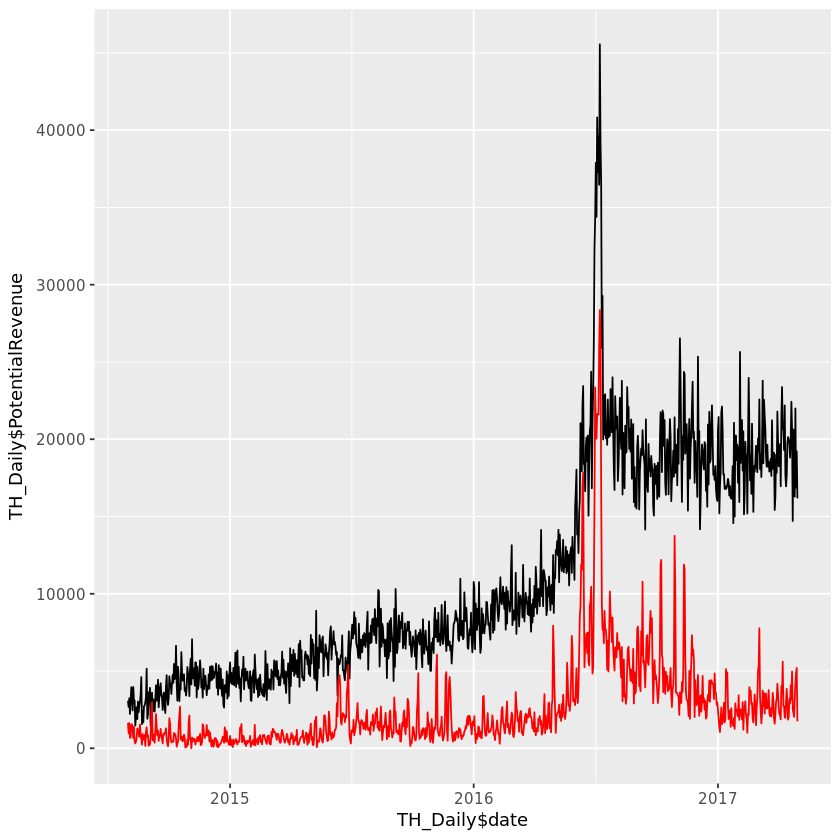

In [14]:
# Plot Potential and Actual Revenue by Date
ggplot() +
geom_line(aes(TH_Daily$date, TH_Daily$PotentialRevenue), colour='black') +
geom_line(aes(TH_Daily$date, TH_Daily$Revenue), colour='red')

# Print file
graph_name = paste(file.path(path.expand('~'),'outputs','Lab4'), "/Revenue_", y, ".png", sep="")
ggsave(graph_name, width = 8, height = 5)

In [15]:
## This function will check if a package is installed, and if not, install it
pkgTest <- function(x) {
  if (!require(x, character.only = TRUE))
  {
    install.packages(x, dep = TRUE)
    if(!require(x, character.only = TRUE)) stop("Package not found")
  }
}

## These lines load the required packages using 'pkgTest' function
packages <- c("foreach", "doParallel")
lapply(packages, pkgTest)

Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


[[1]]
NULL

[[2]]
NULL

## Step 3.1: Creating the parallel function

This step creates the function that can be used in the "foreach" parallel program. Syntax is imperative.

In [16]:
findModel <- function(y, US_P, US_D){  

  print(paste0(y, " beginning"))

  ## Choose market
  TH_P <- subset(US_P, City_State==y)
  
  ## Subset Daily Data by Market
  TH_ID <- as.vector(TH_P$Property.ID)
  TH_D <- US_D[which(US_D$Property.ID %in% TH_ID),]
  
  if(nrow(TH_D) == 0){
    print(paste0(y," had 0 terms"))
  } else {

  # Define Market Characteristics
  City <- TH_P$City[1]
  State <- TH_P$State[1]
  
  ## Modify date format
  TH_D$date <- as.Date(as.character(TH_D$Date), format="%Y-%m-%d")
  TH_D$datepos <- as.POSIXlt(TH_D$date)
  
  ## Compute Property Level Potential Revenue
  TH_D$PotentialRevenue <- 0
  TH_D$PotentialRevenue[which(TH_D$Status=="A" | TH_D$Status=="R")] <- TH_D$Price[which(TH_D$Status=="A" | TH_D$Status=="R")]
  
  ## Compute Property Level Revenue
  TH_D$Revenue <- 0
  TH_D$Revenue[which(TH_D$Status=="R")] <- TH_D$Price[which(TH_D$Status=="R")]
  
  ## Compute Market Level Potential Revenue
  PotentialRevenue <- aggregate(PotentialRevenue ~ date, data=TH_D, FUN=sum, na.rm=TRUE)
  
  ## Compute Market Level Revenue
  Revenue <- aggregate(Revenue ~ date, data=TH_D, FUN=sum, na.rm=TRUE)
  
  ## Merge Revenue Data
  TH_Daily <- merge(PotentialRevenue,Revenue, by = c("date"))
  TH_Daily$RevenueFraction <- as.numeric(TH_Daily$Revenue/TH_Daily$PotentialRevenue)
  TH_Daily$City <- City
  TH_Daily$State <- State
  
  ## SaveRDS
  data_name = paste(file.path(path.expand('~'),'outputs','Lab4'), "/", y, ".rds", sep="")
  saveRDS(TH_Daily, data_name)
  
  # Plot Potential and Actual Revenue by Date
  ggplot() +
    geom_line(aes(TH_Daily$date, TH_Daily$PotentialRevenue), colour='black') +
    geom_line(aes(TH_Daily$date, TH_Daily$Revenue), colour='red')
  
  # print file
  graph_name = paste(file.path(path.expand('~'),'outputs','Lab4'), "/Revenue_", y, ".png", sep="")
  ggsave(graph_name, width = 8, height = 5)
  }
  # print finished city
  print(y)

}

## Step 3.2: Running the foreach parallelization

In [17]:
np <- detectCores()
np

[1] 8

In [18]:
## Set the number of cores to 4 for testing purposes, on a real run, you will need to use (np-1) number of cores
num_cores <- 4

## making this many copy of work
cl <- makeForkCluster(num_cores)

## register this many number of cores
registerDoParallel(cores=(num_cores))

In [19]:
## Import the number of cores
clusterExport(cl, c())

In [20]:
## Display the starting time
Sys.time()
print("starting parallel")

## Run the foreach parallelization
## NOTE: In the real run, we will be using the entire Markets object instead of only 5 markets in the Markets1 variable.
foreach(i=1:length(Markets1), .combine='c') %dopar% {
  findModel(Markets1[i], US_P, US_D)
}

## End the parallelization
stopCluster(cl)

## Show the ending time
Sys.time()
print("ended parallel")

[1] "2019-09-06 15:44:26 UTC"

[1] "starting parallel"


[1] "Eugene_Oregon"             "Palm Desert_California"   
[3] "Verona_Wisconsin"          "Chicago_Illinois"         
[5] "Southbridge_Massachusetts"

[1] "2019-09-06 15:44:49 UTC"

[1] "ended parallel"


## Step 4: Submit job on Supercomputer

The following code is using a bash script instead of an R Script.
This code is based on using the Roger Supercomputer.

### Question 1
We have used the "foreach" library to perform parallelization in this excerise, are there any other libraries that can do the same thing? List at least 3 other different parallelization libraries.

### Question 2
Pick one of the parallelization libraries and give it a try in this excerise by only using 4 cores.

In [ ]:
## Set the number of cores to 4 for testing purposes, on a real run, you will need to use (np-1) number of cores.
num_cores <- 4 

## TODO: You can use your googled example here or just use this excerise, but make sure you only use 4 cores at most!
## You can learn how to write these from secion 3.2 in this excerise, the process should be very similar.